In [1]:
import torch
import matplotlib.pyplot as plt

from pythae.pipelines import TrainingPipeline
from pythae.models import VAE, VAEConfig
from pythae.trainers import BaseTrainerConfig

print(torch.cuda.is_available())
torch.cuda.set_device("cuda:1")
print(torch.cuda.current_device())

/data/parietal/store3/work/pbarbara/anaconda3/envs/fugwenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
1


In [2]:
dataset_to_augment = "../data/processed/"
device = "cpu"
import glob, os
# Load all images
images = []
for ext in ["*.jpg", "*.png"]:
    for f in glob.glob(os.path.join(dataset_to_augment, ext)):
        images.append(f)
# Load images into a tensor
images = torch.stack([torch.from_numpy(plt.imread(f)).permute(2, 0, 1) for f in images])
print("Loaded {} images".format(len(images)))
# Normalize images
images = images / 255.0

training_images = images[:700].to(device)
validation_images = images[800:].to(device)
print(f"Training images shape: {training_images.shape}")
print(f"Validation images shape: {validation_images.shape}")

/tmp/ipykernel_4046/1161432896.py:10: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  images = torch.stack([torch.from_numpy(plt.imread(f)).permute(2, 0, 1) for f in images])


Loaded 811 images
Training images shape: torch.Size([700, 3, 512, 512])
Validation images shape: torch.Size([11, 3, 512, 512])


In [3]:
from torchvision import transforms
# Resize images to 64x64
transform = transforms.Compose([transforms.Resize((64, 64))])
training_images = torch.stack([transform(img) for img in training_images])
validation_images = torch.stack([transform(img) for img in validation_images])
print(f"Training images shape: {training_images.shape}")
print(f"Validation images shape: {validation_images.shape}")

/data/parietal/store3/work/pbarbara/anaconda3/envs/fugwenv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training images shape: torch.Size([700, 3, 64, 64])
Validation images shape: torch.Size([11, 3, 64, 64])


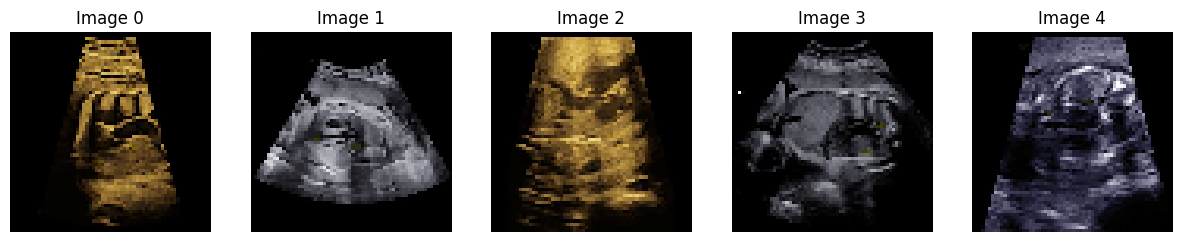

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(training_images[i].permute(1, 2, 0))
    ax[i].set_title(f"Image {i}")
    ax[i].axis("off")
plt.show()

In [5]:
# Set up the training configuration
my_training_config = BaseTrainerConfig(
    output_dir='../models/pythae_default',
    num_epochs=2000,
    learning_rate=1e-3,
    per_device_train_batch_size=200,
    per_device_eval_batch_size=200,
    train_dataloader_num_workers=2,
    eval_dataloader_num_workers=2,
    steps_saving=20,
    optimizer_cls="AdamW",
    optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 5, "factor": 0.5}
)
# Set up the model configuration 
my_vae_config = model_config = VAEConfig(
    input_dim=(3, 64, 64),
    latent_dim=10
)
# Build the model
my_vae_model = VAE(
    model_config=my_vae_config
)
# Build the Pipeline
pipeline = TrainingPipeline(
	training_config=my_training_config,
	model=my_vae_model
)
# Launch the Pipeline
pipeline(
    train_data=training_images, # must be torch.Tensor, np.array or torch datasets
    eval_data=validation_images # must be torch.Tensor, np.array or torch datasets
)

Preprocessing train data...


Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created ../models/pythae_default/VAE_training_2023-11-10_01-41-09. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 2000
 - per_device_train_batch_size: 200
 - per_device_eval_batch_size: 200
 - checkpoint saving every: 20
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.91, 0.995)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.05
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f186a636e10>

Successfully launched training !

Eval of epoch 1/2000: 100%|██████████| 1/1 [00:00<00:00,  3.39batch/s]
--------------------------------------------------------------------------
Train loss: 795.3924
Eval loss: 459.8871
---------------------------------------

In [6]:
from pythae.models import AutoModel
from pythae.samplers import NormalSampler
# Retrieve the lasttrained model
import glob
list_models = glob.glob("../models/pythae_default/VAE_training_*")
list_models.sort()
last_model = list_models[-1]
my_trained_vae = AutoModel.load_from_folder(
    '../models/pythae_default/VAE_training_2023-11-10_01-41-09/final_model'
)
# Define your sampler
my_samper = NormalSampler(
    model=my_trained_vae
)
# Generate samples
gen_data = my_samper.sample(
    num_samples=50,
    batch_size=10,
    output_dir=None,
    return_gen=True
)

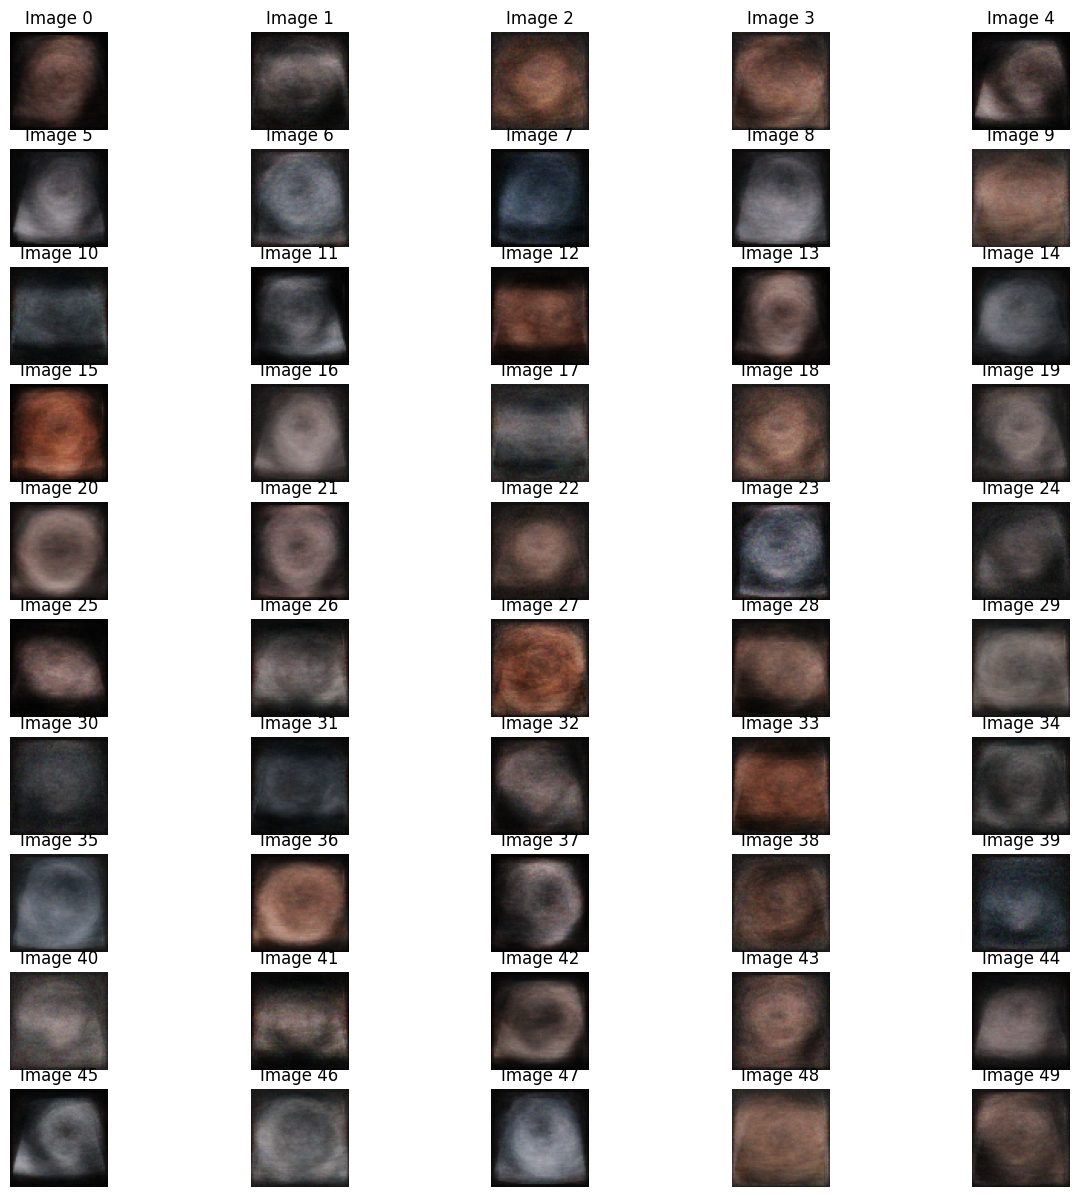

In [7]:
generated_samples = gen_data.cpu().detach()
# Plot the generated samples on a grid
import matplotlib.pyplot as plt
fig, ax = plt.subplots(10, 5, figsize=(15, 15))
for i in range(10):
    for j in range(5):
        ax[i, j].imshow(generated_samples[i * 5 + j].permute(1, 2, 0))
        ax[i, j].set_title(f"Image {i * 5 + j}")
        ax[i, j].axis("off")
plt.show()